# Load & Merge

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import zipfile

# Load centrality measures
with open('/content/drive/MyDrive/Yannis/1990-2016_centrality_analysis_results.pkl', 'rb') as file:
    centrality_data = pickle.load(file)

# Load SPA paths
all_paths_df = pd.read_csv('/content/drive/MyDrive/Yannis/all_paths_df.csv')

In [ ]:
centrality_data.keys()

In [ ]:
# Merge the dataframes
merged_data = pd.merge(centrality_data, all_paths_df, on=['Year', 'Sector', 'Country'])

print(merged_data.head())

**Analyze and Visualize the Integration**

---



**Correlation analysis**

In [ ]:
# Calculate correlation coefficients
correlations = merged_data[['Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality', 'In-Degree Centrality', 'Out-Degree Centrality', 'Bonacich Centrality', 'SPA_Impact']].corr()

print(correlations)

**Key Nodes**

In [ ]:
# Identify key nodes based on centrality measures
top_central_nodes = merged_data.groupby('Year')['Degree Centrality'].nlargest(10).reset_index()

# Analyze SPA paths for key nodes
key_nodes_spa = merged_data[merged_data['Sector'].isin(top_central_nodes['Sector'])]

print(key_nodes_spa.head())


**Visualization**

In [ ]:
import matplotlib.pyplot as plt

# Visualize centrality measures and SPA impacts
def plot_centrality_spa(data, year):
    plt.figure(figsize=(12, 8))

    for sector in data['Sector'].unique():
        sector_data = data[(data['Sector'] == sector) & (data['Year'] == year)]
        plt.plot(sector_data['Degree Centrality'], sector_data['SPA_Impact'], label=sector, marker='o')

    plt.title(f'Centrality vs. SPA Impact ({year})')
    plt.xlabel('Degree Centrality')
    plt.ylabel('SPA Impact')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Example: Plot for the year 1990
plot_centrality_spa(merged_data, 1990)


# Phase Space Reconstruction (Failed)

**Core idea**

In [ ]:
import pandas as pd

# Load your data (assuming you have a DataFrame 'data' with time series of state variables)
data = pd.read_csv('/path/to/your/data.csv')

# Example columns: 'Year', 'Sector', 'Emissions', 'Output', 'Centrality'
# You might need to pivot the data to have sectors as columns and years as index
data_pivot = data.pivot(index='Year', columns='Sector', values=['Emissions', 'Output', 'Centrality'])

#Data normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize each sector's data
normalized_data = {}
for var in ['Emissions', 'Output', 'Centrality']:
    normalized_data[var] = scaler.fit_transform(data_pivot[var])

#Phase Space construction
import numpy as np

def time_delay_embedding(data, tau, m):
    """
    Perform time-delay embedding on the data.
    :param data: Time series data as a 2D numpy array (rows: time, columns: variables)
    :param tau: Time delay
    :param m: Embedding dimension
    :return: Embedded data as a 2D numpy array
    """
    n = data.shape[0]
    embedded_data = np.zeros((n - (m - 1) * tau, m))

    for i in range(m):
        embedded_data[:, i] = data[i * tau : n - (m - 1 - i) * tau]

    return embedded_data

# Choose time delay (tau) and embedding dimension (m)
tau = 1
m = 3

# Perform time-delay embedding for each sector and each variable
embedded_data = {}
for var in ['Emissions', 'Output', 'Centrality']:
    embedded_data[var] = {}
    for sector in data_pivot[var].columns:
        time_series = normalized_data[var][:, data_pivot[var].columns.get_loc(sector)]
        embedded_data[var][sector] = time_delay_embedding(time_series, tau, m)

#Analysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_phase_space(embedded_data, sector, var):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(embedded_data[var][sector][:, 0], embedded_data[var][sector][:, 1], embedded_data[var][sector][:, 2])
    ax.set_title(f'Phase Space Reconstruction - {sector} ({var})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example: Plot phase space for a specific sector and variable
sector_to_plot = 'Electrical and Machinery'
var_to_plot = 'Emissions'

plot_phase_space(embedded_data, sector_to_plot, var_to_plot)


First try with the data and the methodology

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reshaped Degree Centrality shape: (4915, 26)
Q_normalized shape: (2728, 4915)
T_normalized shape: (4915, 4915)
Variable: Emissions, Number of Country-Sectors: 4915
Country-Sector: AFG_Agriculture, Embedded Data Shape: (2726, 3)
Variable: Output, Number of Country-Sectors: 4915
Country-Sector: AFG_Agriculture, Embedded Data Shape: (4913, 3)
Variable: Degree Centrality, Number of Country-Sectors: 4915
Country-Sector: AFG_Agriculture, Embedded Data Shape: (24, 3)


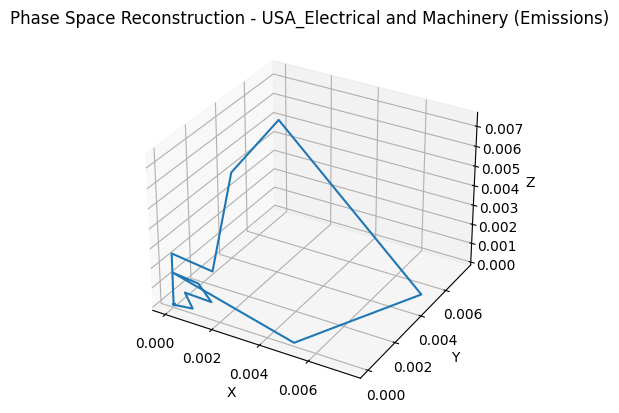

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Mount Google Drive
drive.mount('/content/drive')

# Load the results DataFrame from the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv')

# Reshape Degree Centrality to match (num_country_sectors, num_years)
num_years = 26  # Assuming data spans 26 years (1990 to 2016 inclusive)
num_country_sectors = 4915

degree_centrality_reshaped = results_df['Degree Centrality'].values.reshape(num_country_sectors, num_years)
print("Reshaped Degree Centrality shape:", degree_centrality_reshaped.shape)

# Define the function to handle the time-delay embedding properly
def time_delay_embedding(data, tau, m):
    n = data.shape[0]
    embedded_data = np.zeros((n - (m - 1) * tau, m))
    for i in range(m):
        embedded_data[:, i] = data[i * tau : n - (m - 1 - i) * tau]
    return embedded_data

# Choose time delay (tau) and embedding dimension (m)
tau = 1
m = 3

# Load other necessary data for the analysis
def load_eora26_data(year):
    file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'
    with zipfile.ZipFile(file_path, 'r') as z:
        T = pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None)
        Q = pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None)
        labels_T = pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None)
        labels_Q = pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
    return T, Q, labels_T, labels_Q

# Load data for a specific year for normalization example
year = 1990
T, Q, labels_T, labels_Q = load_eora26_data(year)

# Normalize Q and T
Q_normalized = Q / Q.max().max()
T_normalized = T / T.max().max()

print("Q_normalized shape:", Q_normalized.shape)
print("T_normalized shape:", T_normalized.shape)

# Initialize the embedded data dictionary
embedded_data = {}

# Ensure that the length of the data matches the number of country-sectors
for var, data in zip(['Emissions', 'Output', 'Degree Centrality'],
                     [Q_normalized.values.T, T_normalized.values, degree_centrality_reshaped]):
    embedded_data[var] = {}
    for i in range(num_country_sectors):
        country_sector = labels_T.iloc[i, 1] + "_" + labels_T.iloc[i, 3]  # Combine country and sector for unique label
        if var == 'Degree Centrality':
            time_series = data[i]  # Reshape to match expected shape for single feature
        else:
            time_series = data[i, :]
        embedded_data[var][country_sector] = time_delay_embedding(time_series, tau, m)

# Verify the structure of the embedded data
for var in embedded_data:
    print(f"Variable: {var}, Number of Country-Sectors: {len(embedded_data[var])}")
    for country_sector, data in embedded_data[var].items():
        print(f"Country-Sector: {country_sector}, Embedded Data Shape: {data.shape}")
        break  # Just check the first one for brevity

def plot_phase_space(embedded_data, country_sector, var):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(embedded_data[var][country_sector][:, 0], embedded_data[var][country_sector][:, 1], embedded_data[var][country_sector][:, 2])
    ax.set_title(f'Phase Space Reconstruction - {country_sector} ({var})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example: Plot phase space for a specific country-sector and variable
country_sector_to_plot = 'USA_Electrical and Machinery'  # Example country-sector
var_to_plot = 'Emissions'

plot_phase_space(embedded_data, country_sector_to_plot, var_to_plot)


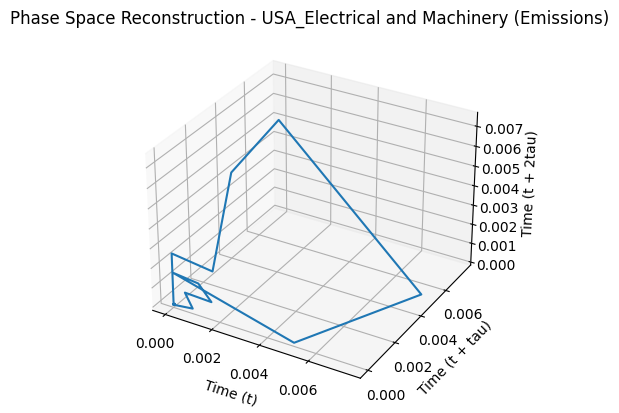

In [ ]:
def plot_phase_space(embedded_data, country_sector, var):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(
        embedded_data[var][country_sector][:, 0],
        embedded_data[var][country_sector][:, 1],
        embedded_data[var][country_sector][:, 2]
    )
    ax.set_title(f'Phase Space Reconstruction - {country_sector} ({var})')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Time (t + tau)')
    ax.set_zlabel('Time (t + 2tau)')
    plt.show()

# Example: Plot phase space for a specific country-sector and variable
country_sector_to_plot = 'USA_Electrical and Machinery'  # Example country-sector
var_to_plot = 'Emissions'

plot_phase_space(embedded_data, country_sector_to_plot, var_to_plot)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load and preprocess the data
def load_and_preprocess_data(years, labels_T):
    emissions_data = {}
    for year in years:
        _, _, Q, _, labels_T, _ = load_eora26_data(year)
        country_sector_labels = labels_T.iloc[:, 3].values
        emissions_data[year] = Q.values[:, :len(country_sector_labels)]
    return emissions_data

# Function to extract time series for a given country-sector
def extract_time_series(emissions_data, country_sector, labels_T):
    time_series = []
    sector_index = labels_T[labels_T.iloc[:, 3] == country_sector].index[0]
    for year in emissions_data:
        time_series.append(emissions_data[year][sector_index])
    return np.array(time_series)

# Function to perform time delay embedding
def time_delay_embedding(time_series, tau, m):
    embedded = np.array([time_series[i:i + m * tau:tau] for i in range(len(time_series) - (m - 1) * tau)])
    return embedded

# Load the data for the required years
years = range(1990, 2017)  # 1990 to 2016
T, _, _, _, labels_T, _ = load_eora26_data(1990)  # Load labels_T to get sector names

# Preprocess the data to get the emissions data across years
emissions_data = load_and_preprocess_data(years, labels_T)

# Extract time series for a specific country-sector
country_sector = 'USA_Electrical and Machinery'
time_series = extract_time_series(emissions_data, country_sector, labels_T)

# Parameters for phase space reconstruction
tau = 1  # Time delay
m = 3  # Embedding dimension

# Perform time delay embedding
embedded_data = time_delay_embedding(time_series, tau, m)

# Plot the phase space reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2])
ax.set_title(f'Phase Space Reconstruction - {country_sector} (Emissions)')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Time (t + tau)')
ax.set_zlabel('Time (t + 2tau)')
plt.show()

# Plot the original time series for reference
plt.figure(figsize=(12, 6))
plt.plot(range(1990, 2017), time_series)  # Time series from 1990 to 2016
plt.title(f'Time Series - {country_sector} (Emissions)')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.grid(True)
plt.show()


ValueError: not enough values to unpack (expected 6, got 4)

# Integration of the metrics into the model

---



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


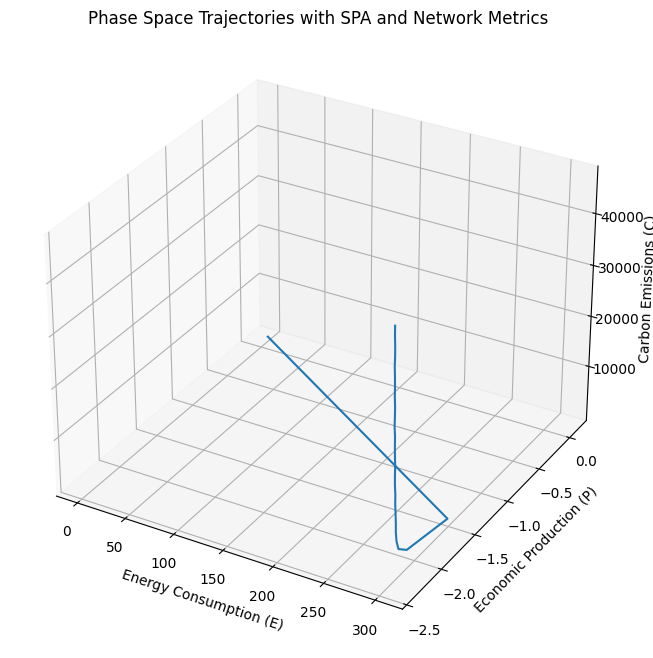

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Mount Google Drive
drive.mount('/content/drive')

# Load centrality measures from the pickle file
centrality_df = pd.read_pickle('/content/drive/MyDrive/Yannis/1990-2016_centrality_analysis_results.pkl')

# Load results from the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv')

# Rename centrality columns to avoid conflicts
centrality_df.rename(columns={
    'Degree Centrality': 'Degree Centrality_centrality',
    'Eigenvector Centrality': 'Eigenvector Centrality_centrality',
    'Betweenness Centrality': 'Betweenness Centrality_centrality',
    'In-Degree Centrality': 'In-Degree Centrality_centrality',
    'Out-Degree Centrality': 'Out-Degree Centrality_centrality',
    'Bonacich Centrality': 'Bonacich Centrality_centrality'
}, inplace=True)

# Merge the DataFrames on the common columns
metrics_df = pd.merge(centrality_df, results_df, on=['Year', 'Sector', 'Country'])

# Extract the metrics for a specific sector and year
sector = 'Electrical and Machinery'
year = 1990
metrics = metrics_df[(metrics_df['Sector'] == sector) & (metrics_df['Year'] == year)].iloc[0]

# Define initial conditions
initial_conditions = [0.1, 0.1, 0.1]  # Example initial conditions for [E, P, C]

# Define time span and evaluation points
t_span = (1990, 2016)
t_eval = np.linspace(1990, 2016, 27)

# Define the dynamic system with SPA and network metrics
def dynamic_system(t, z, metrics):
    E, P, C = z
    total_impact = metrics['Total Impact']
    degree_centrality = metrics['Degree Centrality_centrality']
    eigenvector_centrality = metrics['Eigenvector Centrality_centrality']
    betweenness_centrality = metrics['Betweenness Centrality_centrality']
    bonacich_centrality = metrics['Bonacich Centrality_centrality']
    order_1_impacts = metrics['Order_1_Paths']

    dEdt = alpha * P - beta * E**2 - gamma * np.sin(C) + kappa_1 * total_impact + kappa_2 * degree_centrality
    dPdt = delta * P**2 - epsilon * np.sqrt(E) - zeta * np.log(1 + C) + lambda_1 * eigenvector_centrality + lambda_2 * order_1_impacts
    dCdt = eta * E**2 - theta * np.cos(P) + mu_1 * betweenness_centrality + mu_2 * bonacich_centrality

    return [dEdt, dPdt, dCdt]

# Parameters (to be calibrated)
alpha, beta, gamma = 1.1, 0.4, 0.1
delta, epsilon, zeta = 0.4, 0.1, 0.05
eta, theta = 0.02, 0.3
kappa_1, kappa_2 = 0.1, 0.1
lambda_1, lambda_2 = 0.1, 0.1
mu_1, mu_2 = 0.1, 0.1

# Solve the differential equations
sol = solve_ivp(dynamic_system, t_span, initial_conditions, args=(metrics,), t_eval=t_eval)

# Extract solution
E, P, C = sol.y

# Plot phase space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(E, P, C)
ax.set_xlabel('Energy Consumption (E)')
ax.set_ylabel('Economic Production (P)')
ax.set_zlabel('Carbon Emissions (C)')
ax.set_title('Phase Space Trajectories with SPA and Network Metrics')
plt.show()


In [ ]:
print(fitted_params_df.head())
print(fitted_params_df['Year'].unique())


   Year                                         Parameters
0  1994  [1.22961928 0.14696236 0.10067959 0.24932853 0...
1  1995  [ 1.21022104  0.23045319  0.10899568  0.217644...
2  1996  [1.22141004 0.12409272 0.11193245 0.21069419 0...
3  1997  [1.22171129e+00 1.20315524e-01 1.11743353e-01 ...
4  1998  [1.22170543 0.12029536 0.11174583 0.21118076 0...
[1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


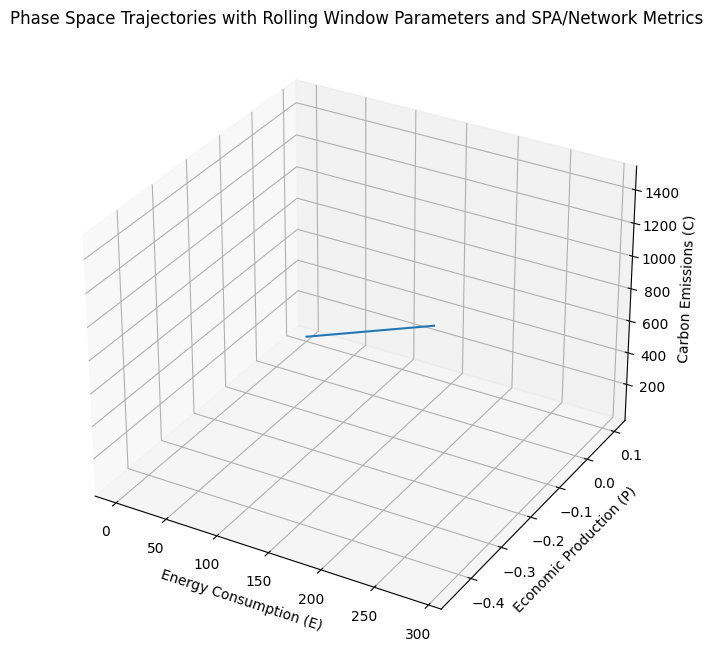

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Mount Google Drive
drive.mount('/content/drive')

# Load centrality measures from the pickle file
centrality_df = pd.read_pickle('/content/drive/MyDrive/Yannis/1990-2016_centrality_analysis_results.pkl')

# Load results from the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv')

# Merge the DataFrames on the common columns
metrics_df = pd.merge(centrality_df, results_df, on=['Year', 'Sector', 'Country'])

# Adjust your t_span and t_eval to start from 1994
t_span = (1994, 2016)
t_eval = np.linspace(1994, 2016, 23)  # 23 points from 1994 to 2016

# Extract the metrics for a specific sector and year
sector = 'Electrical and Machinery'
year = 1994  # Starting from 1994 since parameters are available from 1994
metrics = metrics_df[(metrics_df['Sector'] == sector) & (metrics_df['Year'] == year)].iloc[0]

# Define initial conditions
initial_conditions = [0.1, 0.1, 0.1]  # Example initial conditions for [E, P, C]

# Ensure the Parameters column contains arrays instead of strings
fitted_params_df = pd.read_csv('/content/drive/MyDrive/Yannis/fitted_params_df.csv')
fitted_params_df['Parameters'] = fitted_params_df['Parameters'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# Define the dynamic system with SPA and network metrics using rolling window parameters
def dynamic_system(t, z, metrics, fitted_params_df):
    E, P, C = z
    year = int(t)
    if year in fitted_params_df['Year'].values:
        params = fitted_params_df[fitted_params_df['Year'] == year]['Parameters'].values[0]
        alpha, beta, gamma, delta, epsilon, zeta, eta, theta = params
    else:
        raise ValueError(f"No parameters found for year {year}")

    total_impact = metrics['Total Impact']
    degree_centrality = metrics['Degree Centrality_x']
    eigenvector_centrality = metrics['Eigenvector Centrality_x']
    betweenness_centrality = metrics['Betweenness Centrality_x']
    bonacich_centrality = metrics['Bonacich Centrality_x']
    order_1_impacts = metrics['Order_1_Paths']

    dEdt = alpha * P - beta * E**2 - gamma * np.sin(C) + 0.1 * total_impact + 0.1 * degree_centrality
    dPdt = delta * P**2 - epsilon * np.sqrt(E) - zeta * np.log(1 + C) + 0.1 * eigenvector_centrality + 0.1 * order_1_impacts
    dCdt = eta * E**2 - theta * np.cos(P) + 0.1 * betweenness_centrality + 0.1 * bonacich_centrality

    return [dEdt, dPdt, dCdt]

# Solve the differential equations using the dynamic system
sol = solve_ivp(dynamic_system, t_span, initial_conditions, args=(metrics, fitted_params_df), t_eval=t_eval)

# Extract solution and plot phase space as before
E, P, C = sol.y

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(E, P, C)
ax.set_xlabel('Energy Consumption (E)')
ax.set_ylabel('Economic Production (P)')
ax.set_zlabel('Carbon Emissions (C)')
ax.set_title('Phase Space Trajectories with Rolling Window Parameters and SPA/Network Metrics')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


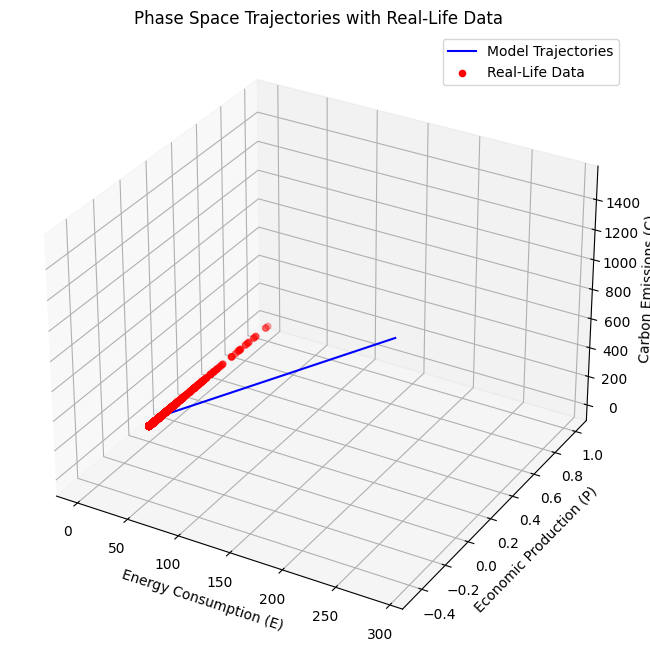

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from sklearn.preprocessing import MinMaxScaler

# Mount Google Drive
drive.mount('/content/drive')

# Load centrality measures from the pickle file
centrality_df = pd.read_pickle('/content/drive/MyDrive/Yannis/1990-2016_centrality_analysis_results.pkl')

# Load results from the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv')

# Merge the DataFrames on the common columns
metrics_df = pd.merge(centrality_df, results_df, on=['Year', 'Sector', 'Country'])

# Adjust your t_span and t_eval to start from 1994
t_span = (1994, 2016)
t_eval = np.linspace(1994, 2016, 23)  # 23 points from 1994 to 2016

# Extract the metrics for a specific sector and year
sector = 'Electrical and Machinery'
year = 1994  # Starting from 1994 since parameters are available from 1994
metrics = metrics_df[(metrics_df['Sector'] == sector) & (metrics_df['Year'] == year)].iloc[0]

# Define initial conditions
initial_conditions = [0.1, 0.1, 0.1]  # Example initial conditions for [E, P, C]

# Ensure the Parameters column contains arrays instead of strings
fitted_params_df = pd.read_csv('/content/drive/MyDrive/Yannis/fitted_params_df.csv')
fitted_params_df['Parameters'] = fitted_params_df['Parameters'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# Define the dynamic system with SPA and network metrics using rolling window parameters
def dynamic_system(t, z, metrics, fitted_params_df):
    E, P, C = z
    year = int(t)
    if year in fitted_params_df['Year'].values:
        params = fitted_params_df[fitted_params_df['Year'] == year]['Parameters'].values[0]
        alpha, beta, gamma, delta, epsilon, zeta, eta, theta = params
    else:
        raise ValueError(f"No parameters found for year {year}")

    total_impact = metrics['Total Impact']
    degree_centrality = metrics['Degree Centrality_x']
    eigenvector_centrality = metrics['Eigenvector Centrality_x']
    betweenness_centrality = metrics['Betweenness Centrality_x']
    bonacich_centrality = metrics['Bonacich Centrality_x']
    order_1_impacts = metrics['Order_1_Paths']

    dEdt = alpha * P - beta * E**2 - gamma * np.sin(C) + 0.1 * total_impact + 0.1 * degree_centrality
    dPdt = delta * P**2 - epsilon * np.sqrt(E) - zeta * np.log(1 + C) + 0.1 * eigenvector_centrality + 0.1 * order_1_impacts
    dCdt = eta * E**2 - theta * np.cos(P) + 0.1 * betweenness_centrality + 0.1 * bonacich_centrality

    return [dEdt, dPdt, dCdt]

# Solve the differential equations using the dynamic system
sol = solve_ivp(dynamic_system, t_span, initial_conditions, args=(metrics, fitted_params_df), t_eval=t_eval)

# Extract solution
E, P, C = sol.y

# Load real-life data
real_life_data = pd.read_csv('/content/drive/MyDrive/Yannis/emissions_production_energy_1990_2016.csv')
real_life_data = real_life_data[real_life_data['Year'] >= 1994]  # Filter data to start from 1994

# Normalize the real-life data to match the scale of the model data
scaler = MinMaxScaler()
real_life_normalized = scaler.fit_transform(real_life_data[['Emissions', 'Production', 'Energy_Consumption']])
real_life_normalized = pd.DataFrame(real_life_normalized, columns=['Emissions', 'Production', 'Energy_Consumption'])
real_life_normalized['Year'] = real_life_data['Year']

# Plot phase space and real-life data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot model trajectories
ax.plot(E, P, C, label='Model Trajectories', color='b')

# Plot real-life data points
ax.scatter(real_life_normalized['Energy_Consumption'], real_life_normalized['Production'], real_life_normalized['Emissions'], label='Real-Life Data', color='r')

ax.set_xlabel('Energy Consumption (E)')
ax.set_ylabel('Economic Production (P)')
ax.set_zlabel('Carbon Emissions (C)')
ax.set_title('Phase Space Trajectories with Real-Life Data')
ax.legend()
plt.show()


In [ ]:
# Load real-life data
real_life_data = pd.read_csv('/content/drive/MyDrive/Yannis/emissions_production_energy_1990_2016.csv')
real_life_data = real_life_data[real_life_data['Year'] >= 1994]  # Filter data to start from 1994

print(real_life_data.head())


       Year                        Sector Country  Emissions     Production  \
19660  1994                   Agriculture     AFG   1.791078   35138.627669   
19661  1994                       Fishing     AFG   0.173567    1711.699567   
19662  1994          Mining and Quarrying     AFG   0.050915   21628.015284   
19663  1994              Food & Beverages     AFG   0.005515  101764.437967   
19664  1994  Textiles and Wearing Apparel     AFG   0.016728   21042.174143   

       Energy_Consumption                    Country_Sector  
19660          344.954100                   AFG_Agriculture  
19661           16.830187                       AFG_Fishing  
19662          203.887780          AFG_Mining and Quarrying  
19663          990.059000              AFG_Food & Beverages  
19664          200.382250  AFG_Textiles and Wearing Apparel  


In [ ]:
# Normalize the real-life data to match the scale of the model data
scaler = MinMaxScaler()
real_life_normalized = scaler.fit_transform(real_life_data[['Emissions', 'Production', 'Energy_Consumption']])
real_life_normalized = pd.DataFrame(real_life_normalized, columns=['Emissions', 'Production', 'Energy_Consumption'])
real_life_normalized['Year'] = real_life_data['Year']

print(real_life_normalized.head())


   Emissions    Production  Energy_Consumption  Year
0   0.007243  1.073716e-05            0.003032   NaN
1   0.000702  5.230367e-07            0.003028   NaN
2   0.000206  6.608780e-06            0.003031   NaN
3   0.000022  3.109572e-05            0.003040   NaN
4   0.000068  6.429767e-06            0.003031   NaN


Original Real-Life Data Head:
       Year                        Sector Country  Emissions     Production  \
19660  1994                   Agriculture     AFG   1.791078   35138.627669   
19661  1994                       Fishing     AFG   0.173567    1711.699567   
19662  1994          Mining and Quarrying     AFG   0.050915   21628.015284   
19663  1994              Food & Beverages     AFG   0.005515  101764.437967   
19664  1994  Textiles and Wearing Apparel     AFG   0.016728   21042.174143   

       Energy_Consumption                    Country_Sector  
19660          344.954100                   AFG_Agriculture  
19661           16.830187                       AFG_Fishing  
19662          203.887780          AFG_Mining and Quarrying  
19663          990.059000              AFG_Food & Beverages  
19664          200.382250  AFG_Textiles and Wearing Apparel  
Real-Life Data Summary:
                Year      Emissions    Production  Energy_Consumption
count  108130.000000  108130.

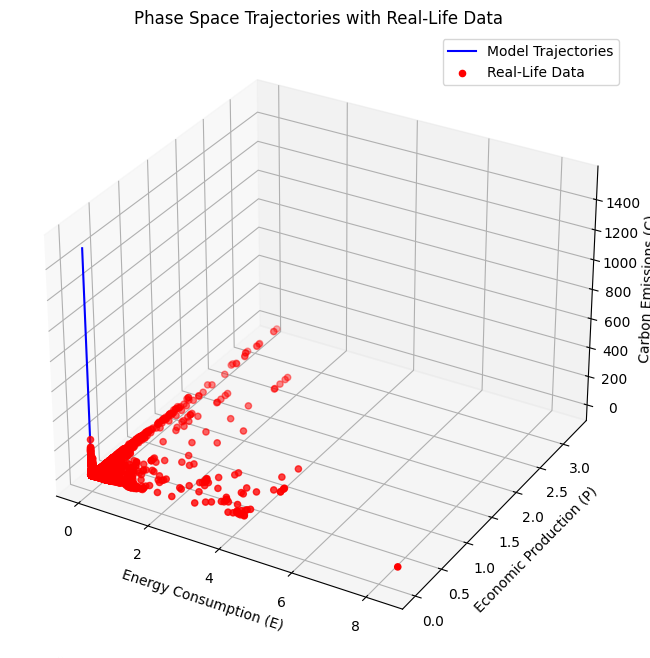

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load real-life data
real_life_data = pd.read_csv('/content/drive/MyDrive/Yannis/emissions_production_energy_1990_2016.csv')
real_life_data = real_life_data[real_life_data['Year'] >= 1994]  # Filter data to start from 1994

# Inspect the raw real-life data for initial values and range
print("Original Real-Life Data Head:")
print(real_life_data.head())

# Extract relevant columns
real_life_emissions = real_life_data['Emissions']
real_life_production = real_life_data['Production']
real_life_energy_consumption = real_life_data['Energy_Consumption']

# Verify the scales of the original data
print("Real-Life Data Summary:")
print(real_life_data.describe())

# Plot phase space and real-life data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot model trajectories
ax.plot(E, P, C, label='Model Trajectories', color='b')

# Plot real-life data points
ax.scatter(real_life_energy_consumption, real_life_production, real_life_emissions, label='Real-Life Data', color='r')

ax.set_xlabel('Energy Consumption (E)')
ax.set_ylabel('Economic Production (P)')
ax.set_zlabel('Carbon Emissions (C)')
ax.set_title('Phase Space Trajectories with Real-Life Data')
ax.legend()
plt.show()


In [ ]:
# Inspect the ranges of the real-life data
print("Real-Life Data Ranges:")
print(real_life_data[['Emissions', 'Production', 'Energy_Consumption']].describe())


Real-Life Data Ranges:
           Emissions    Production  Energy_Consumption
count  108130.000000  1.081300e+05        1.081300e+05
mean        0.209220  1.015763e+07        8.845532e+04
std         3.319427  6.817831e+07        9.765779e+05
min         0.000000  1.000000e-10       -2.538615e+05
25%         0.003200  4.510297e+04        2.969379e+01
50%         0.009741  2.947422e+05        4.108807e+02
75%         0.034547  2.092972e+06        6.711143e+03
max       247.278644  3.272619e+09        8.357922e+07


In [ ]:
fitted_params_df.keys()

Index(['Year', 'Parameters'], dtype='object')

In [ ]:
# Display the range of the parameters
print('fitted_params_df[Parameters].describe()', fitted_params_df['Parameters'].describe())

fitted_params_df[Parameters].describe() count                                                    22
unique                                                   19
top       [1.22165144 0.1206944  0.11176861 0.21063403 0...
freq                                                      4
Name: Parameters, dtype: object


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the fitted parameters from the rolling window optimization
fitted_params_df = pd.read_csv('/content/drive/MyDrive/Yannis/fitted_params_df.csv')

# Clean up the parameter strings
fitted_params_df['Parameters'] = fitted_params_df['Parameters'].str.replace(r'\s+', ', ', regex=True)

# Extract parameters into a separate DataFrame
params_df = pd.DataFrame(fitted_params_df['Parameters'].apply(eval).tolist(), columns=['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta'])

# Display the range of the parameters
print(params_df.describe())

# Load real-life data
real_life_data = pd.read_csv('/content/drive/MyDrive/Yannis/emissions_production_energy_1990_2016.csv')

# Set the initial conditions based on median values of the real-life data
initial_conditions = [
    real_life_data['Energy_Consumption'].median(),
    real_life_data['Production'].median(),
    real_life_data['Emissions'].median()
]

# Define the dynamic system with SPA and network metrics using rolling window parameters
def dynamic_system(t, z, year, metrics, fitted_params_df):
    E, P, C = z
    params = fitted_params_df[fitted_params_df['Year'] == year]['Parameters'].values[0]
    alpha, beta, gamma, delta, epsilon, zeta, eta, theta = eval(params)  # Convert string to tuple of floats

    total_impact = metrics['Total Impact']
    degree_centrality = metrics['Degree Centrality_x']
    eigenvector_centrality = metrics['Eigenvector Centrality_x']
    betweenness_centrality = metrics['Betweenness Centrality_x']
    bonacich_centrality = metrics['Bonacich Centrality_x']
    order_1_impacts = metrics['Order_1_Paths']

    dEdt = alpha * P - beta * E**2 - gamma * np.sin(C) + kappa_1 * total_impact + kappa_2 * degree_centrality
    dPdt = delta * P**2 - epsilon * np.sqrt(E) - zeta * np.log(1 + C) + lambda_1 * eigenvector_centrality + lambda_2 * order_1_impacts
    dCdt = eta * E**2 - theta * np.cos(P) + mu_1 * betweenness_centrality + mu_2 * bonacich_centrality

    return [dEdt, dPdt, dCdt]

# Set additional parameters (adjust as needed)
kappa_1, kappa_2 = 0.1, 0.1
lambda_1, lambda_2 = 0.1, 0.1
mu_1, mu_2 = 0.1, 0.1

# Time span and evaluation points
t_span = (1990, 2016)
t_eval = np.linspace(1990, 2016, 27)

# Extract metrics for a specific sector and year
sector = 'Electrical and Machinery'
year = 1995  # Example year within the range
metrics = metrics_df[(metrics_df['Sector'] == sector) & (metrics_df['Year'] == year)].iloc[0]

# Solve the differential equations using the adjusted initial conditions and parameters
sol = solve_ivp(dynamic_system, t_span, initial_conditions, args=(year, metrics, fitted_params_df), t_eval=t_eval)

# Extract solution
E, P, C = sol.y

# Plot phase space and real-life data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot model trajectories
ax.plot(E, P, C, label='Model Trajectories', color='b')

# Plot real-life data points
ax.scatter(real_life_data['Energy_Consumption'], real_life_data['Production'], real_life_data['Emissions'], label='Real-Life Data', color='r')

ax.set_xlabel('Energy Consumption (E)')
ax.set_ylabel('Economic Production (P)')
ax.set_zlabel('Carbon Emissions (C)')
ax.set_title('Phase Space Trajectories with Real-Life Data')
ax.legend()
plt.show()


SyntaxError: invalid syntax (<string>, line 1)

Try to visualize the paths